# Backtesting -- Different Portfolios on the Efficient Frontier
## Objectives
1. Create a backtesting function to backtest different types of portfolios like, Maximum sharpe ratio (MSR), Global minimum variance (GMV), Equally Weighted (EW), and Targeted Returns Portfolios (TR)
2. Create a function to analyze backtesting results and to create a stastical summary
2. Create a function to backtest and organize the result of more than one portfolio backtests
3. Create a function to analyze the weights change over time of a portfolio

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import sys
sys.path.insert(0, 'python_files')
import functions_1 as fnc
import edhec_risk_kit_127 as erk

r = fnc.local_returns_data()
rm = fnc.change_timeframe(r, 'M')
er = fnc.annualize_returns(rm, 12)

ModuleNotFoundError: No module named 'functions_1'

In [2]:
cov = rm.cov()

Let's create a backtesting function which is capable of backtesting all three types of portfolios Maximum Sharpe Ratio (MSR), Global Minimum Variance (GMV), and Equally Weighted (EW)

In [123]:
def backtest_portfolio(returns, portfolio_type, periods_per_year, starting_balance, starting_step=1, rolling_period=0, weights_column=False,
                       riskfree_rate=0, weight_constraints=1, reweight_period=1, target_return=None, manual_weights=None, weighting=None,  *args, **kwargs):
    """
    Backtests different types of portfolios on a given set of returns and user-defined criteria.

    Parameters:
        returns (pd.DataFrame or pd.Series): A DataFrame or Series containing asset returns over time.
        portfolio_type (str): The type of portfolio to backtest ('GMV', 'MSR', 'TR', 'EW', 'manual', 'other').
        periods_per_year (int): The number of periods in a year for the given returns dataset.
        starting_balance (float): The initial balance of the investment account.
        starting_step (int , optional): Default is 1. The number of starting rows to calculate the initial covariance matrix.
            Required for 'MSR', 'GMV', and 'TR' portfolios, optional for 'EW' portfolio.
        rolling_period (int, optional): The rolling period for calculating covariance matrix. Default is 0 (use all available data).
        weights_column (bool, optional): Whether to include a weight column as type dictionary in the resulting DataFrame. Default is False.
        riskfree_rate (float, optional): The risk-free rate used in calculating the MSR portfolio. Default is 0.
        weight_constraints (float, optional): Weight constraint for portfolio optimization. Default is 1.
        reweight_period (int, optional): The period after which to update the covariance matrix and expected returns.
            Default is 1 (update every period).
        target_return (float or None, optional): Required for 'TR' portfolio. The targeted return for the portfolio. It will  be adjusted according to riskfree_rate
        manual_weights (list or numpy array or None, optional): List of weights. Required if portfolio type is 'manual (Manual Weights)
        weighting (func or None, optional): A function for weighting scheme, default is None.
    Returns:
        pd.DataFrame: A DataFrame containing account value, returns, drawdowns, and optionally weights (if 'weights_column' is True).

    Note:
        The function supports backtesting of four portfolio types: 'GMV' (Global Minimum Variance), 'MSR' (Maximum Sharpe Ratio),
        'TR' (Targeted Return), and 'EW' (Equally Weighted).
    """
    if starting_step is None and (portfolio_type =='MSR' or portfolio_type == 'GMV' or portfolio_type == 'TR'):
        raise ValueError(f"Starting point cannot be None for {portfolio_type}")
    if portfolio_type not in ['EW', 'MSR', 'GMV', 'TR', 'manual']:
        raise ValueError(f"{portfolio_type} is not a valid portfolio type")
    if portfolio_type == 'TR' and target_return is None:
        raise ValueError("target_return cannot be None for Targeted Return Portfolio (TR)")
    if portfolio_type == 'manual' and manual_weights is None:
        raise ValueError(f"manual_weights cannot be None for Manual Weights Portfolio")
    if portfolio_type == 'other' and weighting is None:
        raise ValueError("weighting cannot be None for other portfolio types")
    dates = returns.index
    num_steps = len(dates)
    account_value = starting_balance
    if isinstance(returns, pd.Series):
        returns = pd.DataFrame(returns, columns=['R'])
    account_history = pd.DataFrame(index=dates)
    account_history[f'Account Value {portfolio_type}'] = None
    if weights_column:
        account_history['Weights'] = None
    n_col = len(returns.columns)
    weights = np.repeat(1/10000000000, n_col)
    prev_cov = None
    prev_expected_rets = None
    for step in range(num_steps):
        if starting_step is not None and step >= starting_step and step >= rolling_period and step % reweight_period == 0:
            if rolling_period > 0:
                cov = returns.iloc[step - rolling_period + 1:step + 1].cov()
                expected_rets = fnc.annualize_returns(returns.iloc[step - rolling_period + 1:step + 1], periods_per_year)
                prev_cov = cov
                prev_expected_rets = expected_rets
            else:
                if prev_cov is not None and prev_expected_rets is not None:
                    cov = returns.iloc[:step].cov()
                    expected_rets = fnc.annualize_returns(returns.iloc[:step], periods_per_year)
                    prev_cov = cov
                    prev_expected_rets = expected_rets
                else:
                    # Handle the case when no previous values are available yet
                    cov = returns.iloc[:step].cov()
                    if len(returns.iloc[:step]) < 1:
                        expected_rets = fnc.annualize_returns(returns.iloc[:step + 1], periods_per_year)
                    else:
                        expected_rets = fnc.annualize_returns(returns.iloc[:step], periods_per_year)
                    prev_cov = cov
                    prev_expected_rets = expected_rets
            

            if portfolio_type == 'GMV':
                weights = fnc.gmv(cov, weight_constraints=weight_constraints)
            elif portfolio_type == 'MSR':
                weights = fnc.msr(riskfree_rate, expected_rets, cov, weight_constraints).loc[0, 'Weights']
            elif portfolio_type == 'TR':
                weights = fnc.minimize_vol((target_return + riskfree_rate), expected_rets, cov, weight_constraints=weight_constraints)
            elif portfolio_type == 'EW':
                n = len(returns.columns)
                weights = np.repeat(1/n, n)
            elif portfolio_type == 'manual':
                weights = np.array(manual_weights)
            elif portfolio_type == 'other':
                weights = weighting(returns, **kwargs)

        portfolio_returns = fnc.portfolio_return(weights, returns.iloc[step])
        account_value *= 1 + portfolio_returns

        account_history[f'Account Value {portfolio_type}'].iloc[step] = account_value
        if weights_column:
            account_history['Weights'].at[account_history.index[step]] = {col: weight for col, weight in zip(returns.columns, weights)}
    dr = fnc.drawdown(account_history[[f'Account Value {portfolio_type}']].pct_change())
    backtest_result = {
        'Returns': account_history[f'Account Value {portfolio_type}'].pct_change(),
        f'Account History': account_history[f'Account Value {portfolio_type}'],
        'Drawdown': dr[f'Account Value {portfolio_type}', 'Drawdown'],
        'Previous Peak': dr[f'Account Value {portfolio_type}', 'Previous Peak']
    }
    df = pd.DataFrame(backtest_result)
    if weights_column:
        df['Weights'] = account_history['Weights']
    if starting_step != 1:
        if starting_step > rolling_period:
            df = df.iloc[starting_step:]
        else:
            df = df.iloc[rolling_period:]
    return df


In [4]:
ew = backtest_portfolio(rm.loc['1990':], 'EW', 252, 1000, weights_column=True, starting_step=1)
msr = backtest_portfolio(rm.loc['1990':], 'MSR', 252, 1000, weights_column=True, starting_step=90, reweight_period=90)
gmv = backtest_portfolio(rm.loc['1990':], 'GMV', 252, 1000, weights_column=True, starting_step=90, reweight_period=90)
tr8 = backtest_portfolio(rm.loc['1990':], 'TR', 252, 1000, weights_column=True, starting_step=90, reweight_period=90, target_return=0.08)

c:\Users\user\miniconda3\envs\Data_Science_1\lib\site-packages\pandas\core\frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
c:\Users\user\miniconda3\envs\Data_Science_1\lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\user\miniconda3\envs\Data_Science_1\lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
c:\Users\user\Documents\Data science practice\1. Portfolio construction and analysis\python_files\functions_1.py:397: RuntimeWarning: divide by zero encountered in scalar divide
  return -(r - riskfree_rate)/vol
c:\Users\user\Documents\Data science practice\1. Portfolio construction and analysis\python_files\functions_1.py:397: RuntimeWarning: divide by zero encountered in scalar divide
  return -(r - riskfree_rate)/vol
c:\Users\user\miniconda3\envs\Data_S

<Axes: title={'center': 'Equally Weighted Portfolio Performances'}, xlabel='Date'>

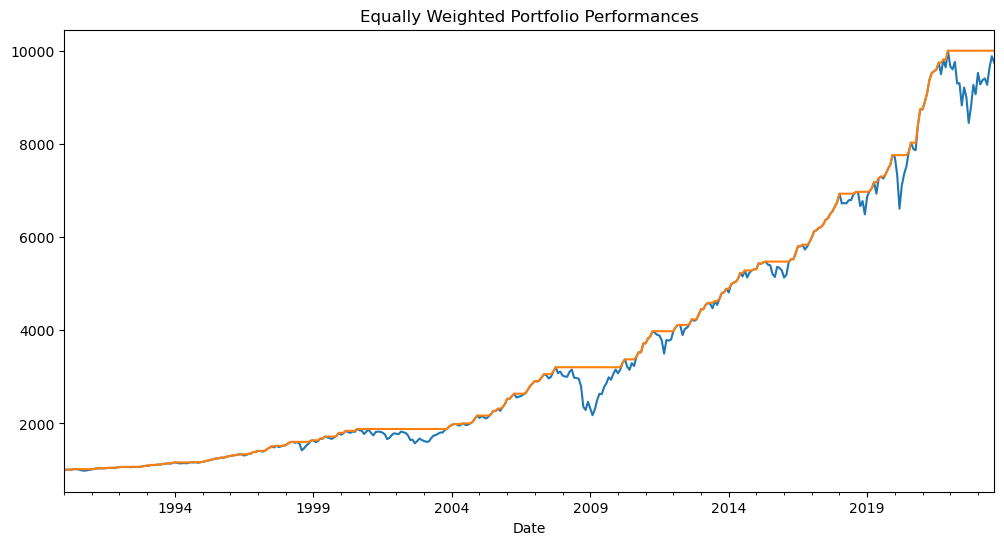

In [5]:
ax = ew['Account History'].plot(figsize=(12,6), title='Equally Weighted Portfolio Performances')
ew['Previous Peak'].plot(ax=ax)

<Axes: title={'center': 'Maximum Sharpe Ratio Portfolio Performances'}, xlabel='Date'>

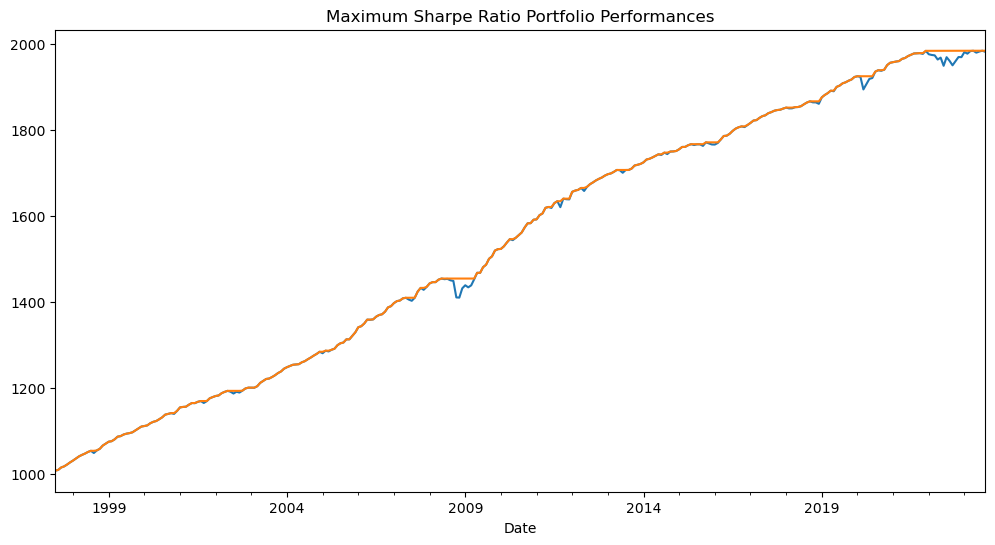

In [6]:
ax = msr['Account History'].plot(figsize=(12,6), title='Maximum Sharpe Ratio Portfolio Performances')
msr['Previous Peak'].plot(ax=ax)

<Axes: title={'center': 'Global Minimum Variance Portfolio Performances'}, xlabel='Date'>

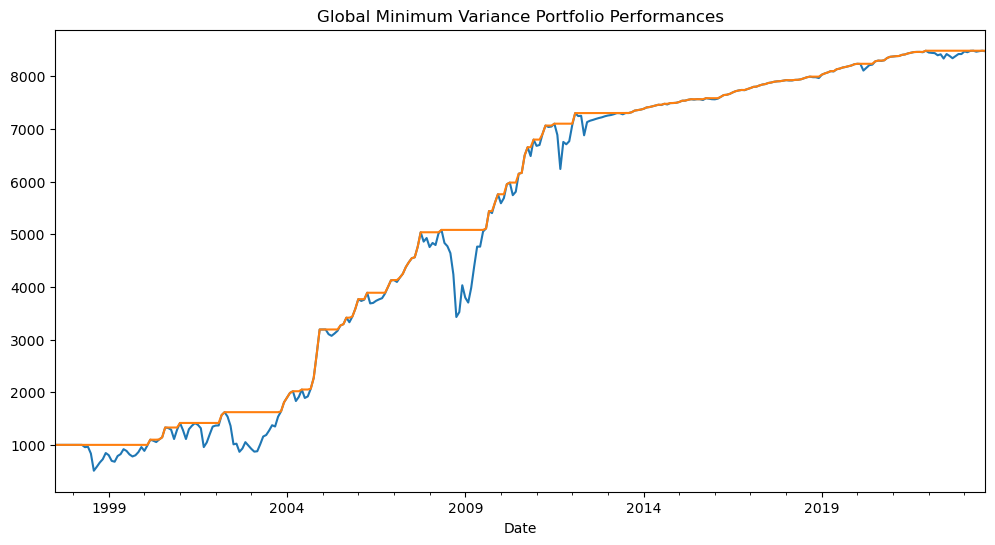

In [7]:
ax = gmv['Account History'].plot(figsize=(12,6), title='Global Minimum Variance Portfolio Performances')
gmv['Previous Peak'].plot(ax=ax)

<Axes: title={'center': 'Target Return 8% Portfolio Performance'}, xlabel='Date'>

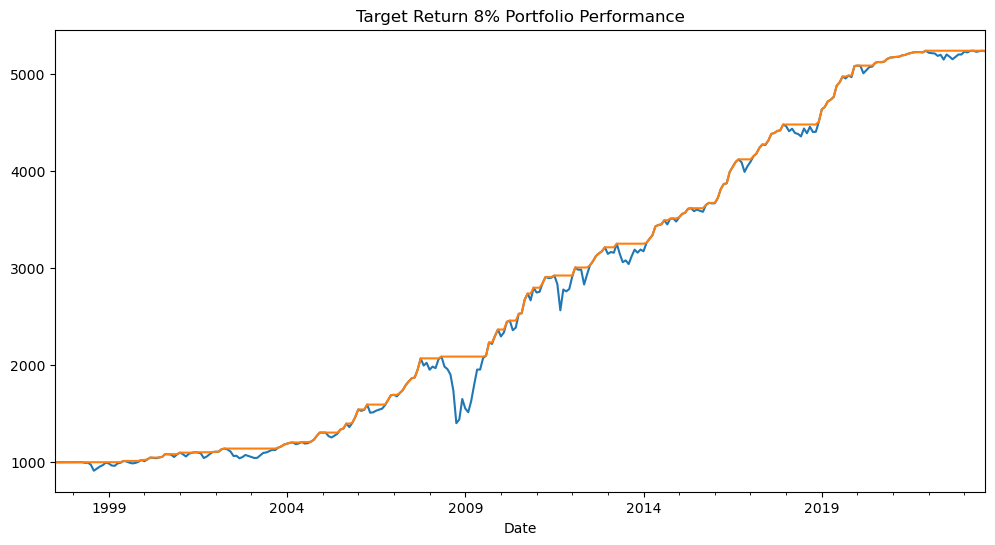

In [8]:
ax = tr8['Account History'].plot(figsize=(12,6), title='Target Return 8% Portfolio Performance')
tr8['Previous Peak'].plot(ax=ax)

In [9]:
col = msr['Weights'].iloc[0].keys()
df = pd.DataFrame(columns=col, index = msr.index)
for date in df.index:
    df.loc[date] = msr['Weights'].loc[date]
df

,Vanguard High Yield Corporate Fund,Vanguard Total Intl Stock Idx Fund,Vanguard Mid Cap Index Fund,S&P 500,Vanguard Value Index Fund,Vanguard Small Cap Value Index Fund,Vanguard Small Cap Index Fund,iShares J.P. Morgan USD Emerging Markets Bond ETF,Vanguard Emerging Markets Stock Index Fund,Vanguard Real Estate Index Fund,SPDR S&P 500 ETF Trust,SPDR Gold Shares
Date,,,,,,,,,,,,
1997-07,0.960683,0.000079,0.002402,0.0,0.026643,0.002402,0.0,0.002402,0.002402,0.002402,0.0,0.002402
1997-08,0.960683,0.000079,0.002402,0.0,0.026643,0.002402,0.0,0.002402,0.002402,0.002402,0.0,0.002402
1997-09,0.960683,0.000079,0.002402,0.0,0.026643,0.002402,0.0,0.002402,0.002402,0.002402,0.0,0.002402
1997-10,0.960683,0.000079,0.002402,0.0,0.026643,0.002402,0.0,0.002402,0.002402,0.002402,0.0,0.002402
1997-11,0.960683,0.000079,0.002402,0.0,0.026643,0.002402,0.0,0.002402,0.002402,0.002402,0.0,0.002402
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04,0.997557,0.0,0.0,0.0,0.002448,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-05,0.997557,0.0,0.0,0.0,0.002448,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-06,0.997557,0.0,0.0,0.0,0.002448,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Summary Statistics for returns

In [10]:

def summary_stats(returns, periods_per_year, riskfree_rate=0):
    """
    Returns a summary stats for all the columns in returns
    """
    if isinstance(returns, pd.Series):
        returns = pd.DataFrame(returns)
    ann_r = returns.aggregate(fnc.annualize_returns, periods_per_year=periods_per_year)
    ann_vol = returns.aggregate(fnc.annualize_vol, periods_per_year=periods_per_year)
    ann_sr = returns.aggregate(fnc.sharpe_ratio, periods_per_year=periods_per_year, riskfree_rate=riskfree_rate)
    dd = returns.aggregate(lambda returns: fnc.drawdown(returns).Drawdown.min())
    skew = returns.aggregate(fnc.skewness)
    kurt = returns.aggregate(fnc.kurtosis)
    cf_var5 = returns.aggregate(fnc.var_gaussian, modified=True)
    hist_cvar = returns.aggregate(fnc.cvar_historic)
    df =  pd.DataFrame({
        'Annualized Returns': ann_r,
        'Annualized Vol': ann_vol,
        'Skewness': skew,
        'Kurtosis': kurt,
        'Cornish-Fisher VaR (5%)': cf_var5,
        'Historic Cvar (5%)': hist_cvar,
        'Sharpe Ratio': ann_sr,
        'Max Drawdown': dd
    })
    df['start dates'] = fnc.start_dates(returns)
    df['end dates'] = returns.index[-1]
    df['Time Period'] = df['start dates'] - df['end dates']
    df = df.drop(columns=['start dates', 'end dates'])
    return df

In [116]:
def weights_change(weights, *args, **kwargs):
    """
    Returns a Dataframe which contains the assets as columns and weights as rows on a particular time period, or a multi indexed dataframes if there is
    more than one column in the 'weights'

    Parameters:
        weights(pd.DataFrame, pd.Series): Weights Series or Dataframe, each row containig a dictionary of asset name and it's respective weight
    Returns:
        pd.DataFrame: A Dataframe containing the given columns as columns and their corresponding weights on each particular instant
    """
    if isinstance(weights, pd.Series):
        weights = pd.DataFrame(weights)
    dfs = []
    if len(weights.columns) == 1:
        weights_df = pd.DataFrame(columns=weights.iloc[0].keys())
        for date in weights.index:
            weights_df.loc[date] = weights.loc[date]
        result_df = weights_df
    else:
        for column in weights.columns:
            columns = list(weights[column].iloc[0].keys())
            weights_df = pd.DataFrame(columns=columns)
            for date in weights.index:
                weight_dict = weights[column].loc[date]
                weights_df.loc[date] = [weight_dict.get(col, 0.0) for col in columns]
            dfs.append(weights_df)
        
    result_df = pd.concat(dfs, axis=1)
    multi_index = pd.MultiIndex.from_product([weights.columns, columns])
    result_df.columns = multi_index
    
    return result_df


In [21]:
def combined_backtesting_result(r, portfolios, periods_per_year, rolling_period=0, riskfree_rate=0, weight_constraints=1,
                                 reweight_period=1, starting_step=None, target_returns=None, weights_column=False, starting_balance=1000, *args, **kwargs):
    """
    Combine and analyze backtesting results for multiple portfolios.

    This function calculates and combines the backtesting results for a list of portfolios, such as 
    Equally Weighted (EW), Maximum Sharpe Ratio (MSR), Global Minimum Variance (GMV), and Target 
    Returns (TR) portfolios.

    Parameters:
       r (pd.DataFrame or pd.Series): Returns dataset.
       portfolios (list): List of portfolio types ('MSR', 'EW', 'GMV', 'TR').
       periods_per_year (int): Number of periods in a year for the given returns dataset.
       rolling_period (int, optional): Rolling period for calculating covariance matrix. Default is 0 (use all available data).
       riskfree_rate (float, optional): Risk-free rate used in calculating the MSR portfolio. Default is 0.
       weight_constraints (float, optional): Weight constraint for portfolio optimization. Default is 1.
       reweight_period (int, optional): Period after which to update the covariance matrix and expected returns.
            Default is 1 (update every period).
       starting_step (int or None, optional): Number of starting rows to calculate the initial covariance matrix.
            Required for 'MSR', 'GMV', and 'TR' portfolios, optional for 'EW' portfolio.
       target_returns (list or float, optional): List of target returns for TR portfolio or a float for a single target return. These returns will be
            adjusted according to the Risk Free Rate provided.
       weights_column (bool, optional): Include a weight column in the resulting DataFrame. Default is False.
       starting_balance (float, optional): Initial balance of the investment account. Default is 1000
       *args, **kwargs: Additional arguments.

    Returns:
       pd.DataFrame: A multiindex DataFrame containing portfolio types as main columns and backtesting
       results (returns, account history, drawdowns, etc.) as subcolumns.
    """
    if 'TR' in portfolios:
        portfolio_names = {
        'EW': ['Equally Weighted'],
        'MSR': ['Maximum Sharpe Ratio'],
        'GMV': ['Global Minimum Variance'],
        'TR': [f'Target Returns {target_return*100}%' for target_return in target_returns]
    }
    else:
        portfolio_names = {
        'EW': ['Equally Weighted'],
        'MSR': ['Maximum Sharpe Ratio'],
        'GMV': ['Global Minimum Variance']
        }

    if 'TR' in portfolios and target_returns is None:
        raise ValueError("target_returns cannot be None for Target Returns Portfolio (TR)")
    invalid_portfolios = [p for p in portfolios if p not in portfolio_names.keys()]
    if invalid_portfolios:
        raise ValueError(f"{invalid_portfolios} are not valid portfolio types")
    column_names = []
    for portfolio in portfolios:
        column_names.extend(portfolio_names[portfolio])
    
    portfolio_dfs = []

    for portfolio in portfolios:
        if portfolio != 'TR':
            df = backtest_portfolio(r, portfolio_type=portfolio, periods_per_year=periods_per_year, starting_balance=starting_balance, weights_column=weights_column,
                                    starting_step=starting_step, riskfree_rate=riskfree_rate, rolling_period=rolling_period, reweight_period=reweight_period,
                                    weight_constraints=weight_constraints)
            portfolio_dfs.append(df)
        else:
            for target_return in target_returns:
                df = backtest_portfolio(r, portfolio_type=portfolio, periods_per_year=periods_per_year, starting_balance=starting_balance, weights_column=weights_column,
                                    starting_step=starting_step, riskfree_rate=riskfree_rate, rolling_period=rolling_period, reweight_period=reweight_period,
                                    weight_constraints=weight_constraints, target_return=target_return)
                portfolio_dfs.append(df)

    # Combine all individual portfolio DataFrames into a single DataFrame
    result_df = pd.concat(portfolio_dfs, axis=1)

    # Create a MultiIndex for the columns
    multi_index = pd.MultiIndex.from_product([column_names, df.columns])
    result_df.columns = multi_index
    
    return result_df


In [22]:
step = 0.02
n = 5
start = 2
target_returns = [i*step for i in range(start, n+start)]
target_returns

[0.04, 0.06, 0.08, 0.1, 0.12]

In [23]:
comb_bct = combined_backtesting_result(rm.loc['1990':], ['MSR', 'GMV', 'EW', 'TR'], periods_per_year=12, target_returns=target_returns, riskfree_rate=0.02, starting_step=36, reweight_period=3,
                                        weight_constraints=1, weights_column=True, rolling_period=36)

c:\Users\user\Documents\Data science practice\1. Portfolio construction and analysis\python_files\functions_1.py:397: RuntimeWarning: divide by zero encountered in scalar divide
  return -(r - riskfree_rate)/vol
c:\Users\user\Documents\Data science practice\1. Portfolio construction and analysis\python_files\functions_1.py:397: RuntimeWarning: divide by zero encountered in scalar divide
  return -(r - riskfree_rate)/vol
c:\Users\user\miniconda3\envs\Data_Science_1\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\Users\user\Documents\Data science practice\1. Portfolio construction and analysis\python_files\functions_1.py:397: RuntimeWarning: divide by zero encountered in scalar divide
  return -(r - riskfree_rate)/vol
c:\Users\user\miniconda3\envs\Data_Science_1\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\Users\user\Documents\Data

In [24]:
comb_bct.head()

Maximum Sharpe Ratio                                         \
                     Returns Account History Drawdown Previous Peak   
Date                                                                  
1993-01             0.005971     1005.970528      0.0   1005.970528   
1993-02             0.005777     1011.782483      0.0   1011.782483   
1993-03             0.005582     1017.430616      0.0   1017.430616   
1993-04             0.004271     1021.775961      0.0   1021.775961   
1993-05             0.004941     1026.824106      0.0   1026.824106   

                                                            \
                                                   Weights   
Date                                                         
1993-01  {'Vanguard High Yield Corporate Fund': 0.98076...   
1993-02  {'Vanguard High Yield Corporate Fund': 0.98076...   
1993-03  {'Vanguard High Yield Corporate Fund': 0.98076...   
1993-04  {'Vanguard High Yield Corporate Fund': 0.98308...   
1993-05  {'Vanguard High Yield Corporate Fund': 0.98308...   

        Global Minimum Variance                                              \
                        Returns Account History      Drawdown Previous Peak   
Date                                                                          
1993-01            8.644778e-10     1000.000001  0.000000e+00   1000.000001   
1993-02            1.399127e-03     1001.399128  0.000000e+00   1001.399128   
1993-03            3.867885e-03     1005.272424  0.000000e+00   1005.272424   
1993-04           -1.363035e-09     1005.272423 -1.363035e-09   1005.272424   
1993-05            1.644503e-09     1005.272424  0.000000e+00   1005.272424   

                                                            ...  \
                                                   Weights  ...   
Date                                                        ...   
1993-01  {'Vanguard High Yield Corporate Fund': 3.22666...  ...   
1993-02  {'Vanguard High Yield Corporate Fund': 3.22666...  ...   
1993-03  {'Vanguard High Yield Corporate Fund': 3.22666...  ...   
1993-04  {'Vanguard High Yield Corporate Fund': 0.0, 'V...  ...   
1993-05  {'Vanguard High Yield Corporate Fund': 0.0, 'V...  ...   

        Target Returns 10.0%                                          \
                     Returns Account History  Drawdown Previous Peak   
Date                                                                   
1993-01             0.020109     1020.109208  0.000000   1020.109208   
1993-02            -0.006512     1013.465778 -0.006512   1020.109208   
1993-03             0.016620     1030.309152  0.000000   1030.309153   
1993-04            -0.015563     1014.274261 -0.015563   1030.309153   
1993-05             0.025882     1040.526142  0.000000   1040.526142   

                                                            \
                                                   Weights   
Date                                                         
1993-01  {'Vanguard High Yield Corporate Fund': 0.40812...   
1993-02  {'Vanguard High Yield Corporate Fund': 0.40812...   
1993-03  {'Vanguard High Yield Corporate Fund': 0.40812...   
1993-04  {'Vanguard High Yield Corporate Fund': 0.27742...   
1993-05  {'Vanguard High Yield Corporate Fund': 0.27742...   

        Target Returns 12.0%                                          \
                     Returns Account History  Drawdown Previous Peak   
Date                                                                   
1993-01             0.025795     1025.794991  0.000000   1025.794991   
1993-02            -0.011106     1014.402911 -0.011106   1025.794991   
1993-03             0.021232     1035.940632  0.000000   1035.940632   
1993-04            -0.023144     1011.964924 -0.023144   1035.940632   
1993-05             0.033918     1046.288753  0.000000   1046.288753   

                                                            
                                                   Weights  

In [25]:
comb_rets = comb_bct.xs('Returns', level=1, axis=1)
comb_weights = comb_bct.xs('Weights', level=1, axis=1)

In [26]:
summary_stats(comb_rets, 12, 0.02)

,Annualized Returns,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic Cvar (5%),Sharpe Ratio,Max Drawdown,Time Period
Maximum Sharpe Ratio,0.070269,0.084594,-0.191905,13.454511,0.030308,0.052198,0.583496,-0.226096,<-367 * MonthEnds>
Global Minimum Variance,0.008441,0.010041,-3.709439,39.640679,0.004220,0.006582,-1.130473,-0.039159,<-367 * MonthEnds>
Equally Weighted,0.074225,0.094651,-0.960227,7.427344,0.043057,0.063623,0.562521,-0.321435,<-367 * MonthEnds>
Target Returns 4.0%,0.050801,0.052673,-1.756931,23.922009,0.021013,0.033720,0.574204,-0.192136,<-367 * MonthEnds>
Target Returns 6.0%,0.067383,0.072038,-1.663400,17.366490,0.031209,0.046988,0.645879,-0.247170,<-367 * MonthEnds>
Target Returns 8.0%,0.083225,0.087029,-1.200351,11.019570,0.038085,0.056488,0.713366,-0.253499,<-367 * MonthEnds>
Target Returns 10.0%,0.095837,0.101551,-1.043215,8.745473,0.044751,0.065141,0.733305,-0.260743,<-367 * MonthEnds>
Target Returns 12.0%,0.103758,0.113759,-0.862854,7.080154,0.050022,0.073220,0.722966,-0.267952,<-367 * MonthEnds>


In [117]:
weights_df = weights_change(comb_weights)
weights_df.head()

Maximum Sharpe Ratio                                     \
        Vanguard High Yield Corporate Fund Vanguard Total Intl Stock Idx Fund   
1993-01                           0.980762                       0.000000e+00   
1993-02                           0.980762                       0.000000e+00   
1993-03                           0.980762                       0.000000e+00   
1993-04                           0.983083                       2.835238e-09   
1993-05                           0.983083                       2.835238e-09   

                                                                             \
        Vanguard Mid Cap Index Fund       S&P 500 Vanguard Value Index Fund   
1993-01                0.000000e+00  4.083855e-08                  0.019238   
1993-02                0.000000e+00  4.083855e-08                  0.019238   
1993-03                0.000000e+00  4.083855e-08                  0.019238   
1993-04                2.843870e-09  3.699410e-09                  0.016917   
1993-05                2.843870e-09  3.699410e-09                  0.016917   

                                                                           \
        Vanguard Small Cap Value Index Fund Vanguard Small Cap Index Fund   
1993-01                        0.000000e+00                  4.640593e-08   
1993-02                        0.000000e+00                  4.640593e-08   
1993-03                        0.000000e+00                  4.640593e-08   
1993-04                        2.843408e-09                  0.000000e+00   
1993-05                        2.843408e-09                  0.000000e+00   

                                                           \
        iShares J.P. Morgan USD Emerging Markets Bond ETF   
1993-01                                      0.000000e+00   
1993-02                                      0.000000e+00   
1993-03                                      0.000000e+00   
1993-04                                      2.843676e-09   
1993-05                                      2.843676e-09   

                                                    \
        Vanguard Emerging Markets Stock Index Fund   
1993-01                               0.000000e+00   
1993-02                               0.000000e+00   
1993-03                               0.000000e+00   
1993-04                               2.843687e-09   
1993-05                               2.843687e-09   

                                         ...        Target Returns 12.0%  \
        Vanguard Real Estate Index Fund  ... Vanguard Mid Cap Index Fund   
1993-01                    0.000000e+00  ...                2.081668e-17   
1993-02                    0.000000e+00  ...                2.081668e-17   
1993-03                    0.000000e+00  ...                2.081668e-17   
1993-04                    2.843365e-09  ...                0.000000e+00   
1993-05                    2.843365e-09  ...                0.000000e+00   

                                                 \
              S&P 500 Vanguard Value Index Fund   
1993-01  2.775558e-17                       0.0   
1993-02  2.775558e-17                       0.0   
1993-03  2.775558e-17                       0.0   
1993-04  1.214306e-17                       0.0   
1993-05  1.214306e-17                       0.0   

                                                                           \
        Vanguard Small Cap Value Index Fund Vanguard Small Cap Index Fund   
1993-01                        3.469447e-18                      0.823295   
1993-02                        3.469447e-18                      0.823295   
1993-03                        3.469447e-18                      0.823295   
1993-04                        0.000000e+00                      0.996802   
1993-05                        0.000000e+00                      0.996802   

                                                           \
        iShares J.P. Morgan USD Emerging Markets Bond ETF   


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


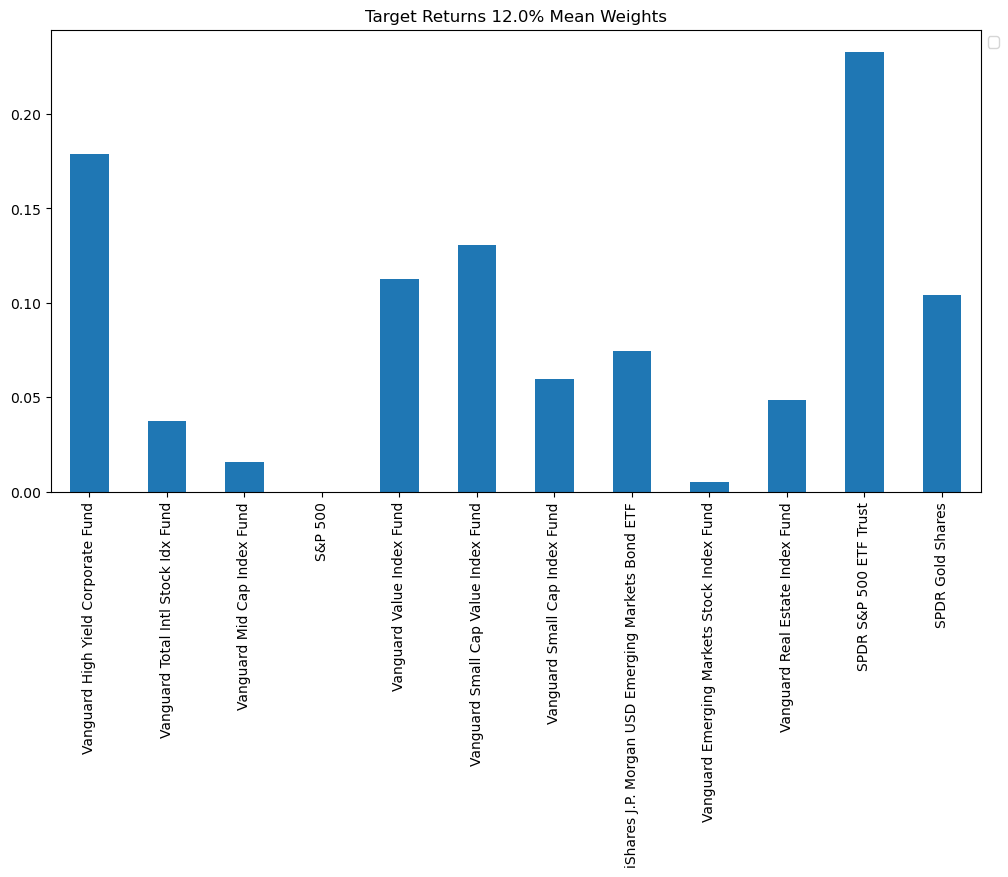

In [29]:
column = 'Target Returns 12.0%'
weights_df[column].mean().plot(kind='bar', figsize=(12, 6), title=f'{column} Mean Weights')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))

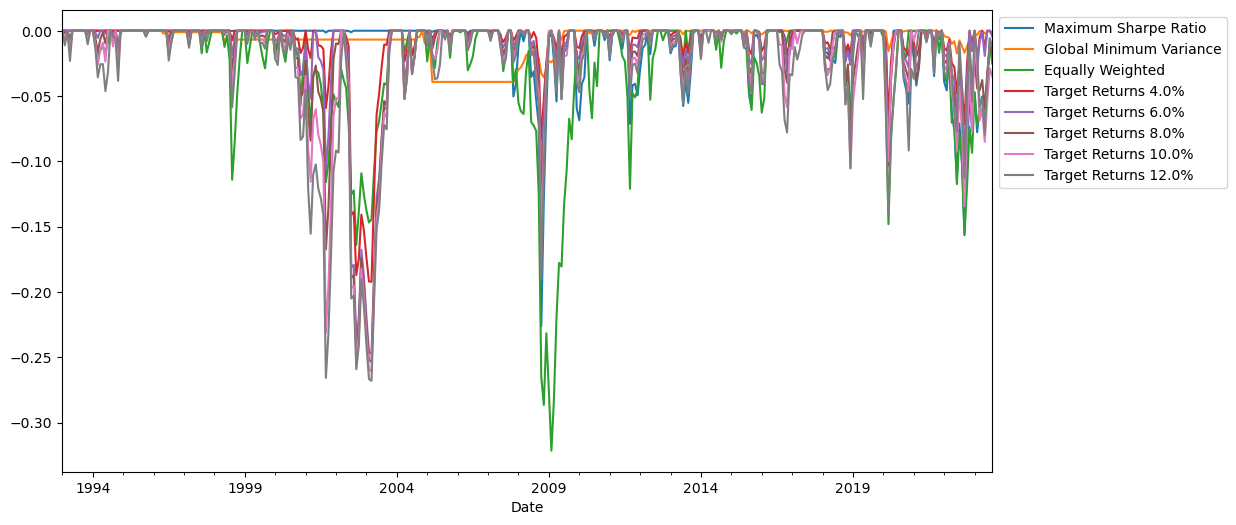

In [30]:
comb_dr = comb_bct.xs('Drawdown', axis=1, level=1)
comb_dr.plot(figsize=(12,6))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))

In [31]:
summary_stats(rm.loc['1993':], 12, riskfree_rate=0.02)

,Annualized Returns,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic Cvar (5%),Sharpe Ratio,Max Drawdown,Time Period
Vanguard High Yield Corporate Fund,0.026452,0.008545,-1.850314,12.984747,0.002511,0.004310,0.741485,-0.019160,<-367 * MonthEnds>
Vanguard Total Intl Stock Idx Fund,0.057493,0.125968,-0.601857,4.991036,0.058902,0.087561,0.292182,-0.431527,<-367 * MonthEnds>
Vanguard Mid Cap Index Fund,0.081045,0.150507,-0.722419,5.890821,0.069847,0.101585,0.398183,-0.464033,<-367 * MonthEnds>
S&P 500,0.085685,0.147091,-0.607200,3.978521,0.068151,0.095850,0.438416,-0.495812,<-367 * MonthEnds>
Vanguard Value Index Fund,0.105935,0.109506,-0.732390,4.587853,0.048239,0.069247,0.770585,-0.353366,<-367 * MonthEnds>
Vanguard Small Cap Value Index Fund,0.078871,0.155918,-0.809971,6.283032,0.073371,0.109752,0.370658,-0.441313,<-367 * MonthEnds>
Vanguard Small Cap Index Fund,0.098236,0.156110,-0.634153,4.633361,0.071448,0.099081,0.492027,-0.419107,<-367 * MonthEnds>
iShares J.P. Morgan USD Emerging Markets Bond ETF,0.040528,0.068765,-0.403500,36.437163,0.017929,0.041078,0.293103,-0.225243,<-367 * MonthEnds>
Vanguard Emerging Markets Stock Index Fund,0.051745,0.138810,-0.292478,8.372798,0.059724,0.093377,0.224464,-0.505811,<-367 * MonthEnds>
Vanguard Real Estate Index Fund,0.066314,0.117072,-0.931931,12.262499,0.051647,0.078476,0.388396,-0.414971,<-367 * MonthEnds>


In [32]:
fnc.start_dates(r)

{'S&P 500': Timestamp('1928-01-03 00:00:00'),
 'Vanguard High Yield Corporate Fund': Timestamp('1980-01-03 00:00:00'),
 'Vanguard Small Cap Index Fund': Timestamp('1980-01-03 00:00:00'),
 'Vanguard Value Index Fund': Timestamp('1992-11-02 00:00:00'),
 'SPDR S&P 500 ETF Trust': Timestamp('1993-02-01 00:00:00'),
 'Vanguard Total Intl Stock Idx Fund': Timestamp('1996-04-30 00:00:00'),
 'Vanguard Mid Cap Index Fund': Timestamp('1998-05-22 00:00:00'),
 'Vanguard Small Cap Value Index Fund': Timestamp('1998-05-22 00:00:00'),
 'Vanguard Real Estate Index Fund': Timestamp('2004-09-30 00:00:00'),
 'SPDR Gold Shares': Timestamp('2004-11-19 00:00:00'),
 'Vanguard Emerging Markets Stock Index Fund': Timestamp('2005-03-11 00:00:00'),
 'iShares J.P. Morgan USD Emerging Markets Bond ETF': Timestamp('2007-12-20 00:00:00')}